<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/main/C4/W3/ungraded_labs/C4_W3_Lab_2_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Using a multi-layer LSTM for forecasting

In this lab, you will use the same RNN architecure in the first lab but will instead stack [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers instead of `SimpleRNN`.

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import tensorflow as tf
import warnings # Supress warnings
warnings.filterwarnings('ignore')

## Utilities

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    ax = plt.axes()
    ax.set_facecolor('None')
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.

    Args:
      time (array of int) - contains the time steps
      slope (float) - determines the direction and steepness of the line

    Returns:
      series (array of float) - measurements that follow a straight line
    """

    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish

    Args:
      season_time (array of float) - contains the measurements per time step

    Returns:
      data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """

    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period

    Args:
      time (array of int) - contains the time steps
      period (int) - number of time steps before the pattern repeats
      amplitude (int) - peak measured value in a period
      phase (int) - number of time steps to shift the measured values

    Returns:
      data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """

    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal

    Args:
      time (array of int) - contains the time steps
      noise_level (float) - scaling factor for the generated signal
      seed (int) - number generator seed for repeatability

    Returns:
      noise (array of float) - the noisy signal
    """

    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Thesis/Datasets

Mounted at /content/drive
/content/drive/MyDrive/Thesis/Datasets


In [ ]:
df = pd.read_csv("weekly_sales_data.csv")
# Convert the 'Date' column to datetime type
#df['Date'] = pd.to_datetime(df['Unnamed: 0'])
#df.drop('Unnamed: 0', axis=1, inplace=True)
# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

<class 'numpy.ndarray'>


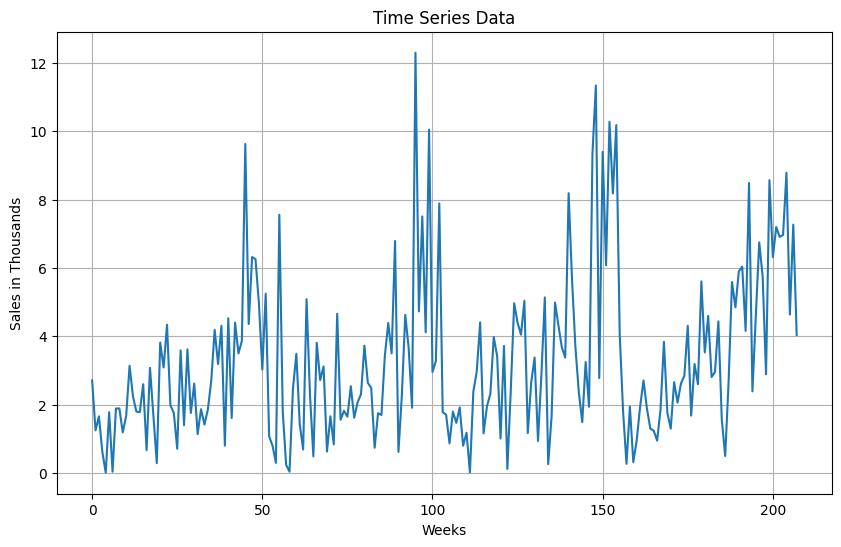

In [ ]:

time = np.arange(len(df.index), dtype="float32")
date = df.index
series = df['sales'].values
print(type(series))

# Plot the results
#plot_series(date, series)

# Preview the data
plot_series(time, series, xlabel='Weeks', ylabel='Sales in Thousands', title='Time Series Data')

## Split the Dataset

In [ ]:
print(len(series))
print(len(series) * 3 / 4)

208
156.0


In [ ]:
# Define the split time
split_time = round(len(series) * 3 / 4)

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
print(len(time_valid))

52


## Prepare Features and Labels

In [ ]:
# Parameters
window_size = 52
batch_size = 16
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

As mentioned, you will swap `SimpleRNN` for `LSTM` in this lab. It is also set as bidirectional below but feel free to revise later and see what results you get. LSTMs are much more complex in their internal architecture than simpleRNNs. It implements a cell state that allows it to remember sequences better than simple implementations. This added complexity results in a bigger set of parameters to train and you'll see that when you print the model summary below.

In [ ]:
node = int(52)

In [ ]:
# Build the Model
model_tune = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[window_size]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(node, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(node)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 52, 1)             0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 52, 104)          22464     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 104)              65312     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 105       
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 87,881
Trainable params: 87,881
Non-trai

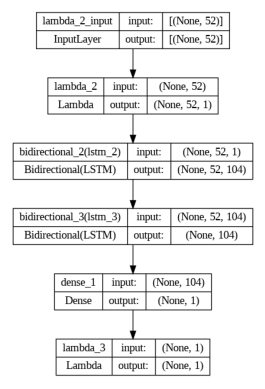

In [ ]:
from io import BytesIO
# Create a buffer to save the model summary image
buffer = BytesIO()

# Plot the model summary and save it to a file
tf.keras.utils.plot_model(model_tune, to_file="model_summary.png", show_shapes=True, show_layer_names=True)

# Display the saved image
img = plt.imread("model_summary.png")
plt.imshow(img)
plt.axis('off')
plt.show()

## Tune the Learning Rate

As usual, you will pick a learning rate by running the tuning code below.

In [ ]:

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()

# Set the training parameters
model_tune.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model_tune.fit(dataset, epochs=200, callbacks=[lr_schedule])


Epoch 1/200
7/7 [==============================] - 7s 18ms/step - loss: 53.2612 - lr: 1.0000e-08
Epoch 2/200
7/7 [==============================] - 0s 15ms/step - loss: 53.2579 - lr: 1.1220e-08
Epoch 3/200
7/7 [==============================] - 0s 13ms/step - loss: 53.2540 - lr: 1.2589e-08
Epoch 4/200
7/7 [==============================] - 0s 12ms/step - loss: 53.2497 - lr: 1.4125e-08
Epoch 5/200
7/7 [==============================] - 0s 18ms/step - loss: 53.2451 - lr: 1.5849e-08
Epoch 6/200
7/7 [==============================] - 0s 15ms/step - loss: 53.2403 - lr: 1.7783e-08
Epoch 7/200
7/7 [==============================] - 0s 17ms/step - loss: 53.2348 - lr: 1.9953e-08
Epoch 8/200
7/7 [==============================] - 0s 18ms/step - loss: 53.2284 - lr: 2.2387e-08
Epoch 9/200
7/7 [==============================] - 0s 19ms/step - loss: 53.2213 - lr: 2.5119e-08
Epoch 10/200
7/7 [==============================] - 0s 17ms/step - loss: 53.2131 - lr: 2.8184e-08
Epoch 11/200
7/7 [===========

(1e-08, 0.001, 0.0, 60.0)

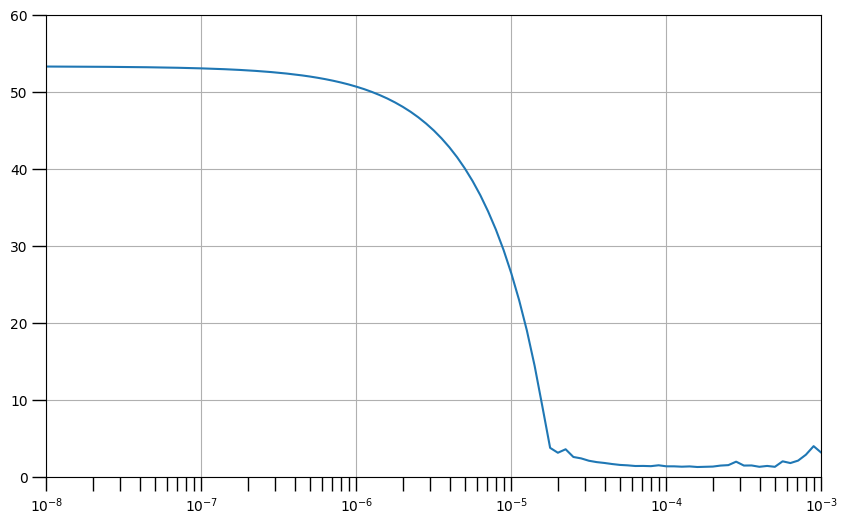

In [ ]:

# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(200) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 60])


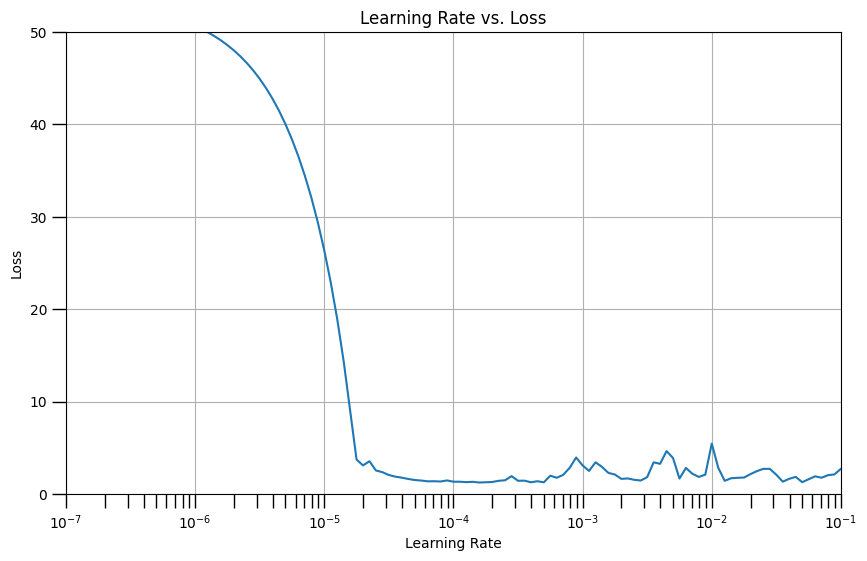

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(200) / 20))

# Set the figure size and create a transparent background
fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')

# Set the grid
ax.grid(True)

# Plot the loss in log scale
ax.semilogx(lrs, history.history["loss"])

# Set the plot title
ax.set_title("Learning Rate vs. Loss")

# Set the x-label
ax.set_xlabel("Learning Rate")

# Set the y-label
ax.set_ylabel("Loss")

# Increase the tickmarks size
ax.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
ax.axis([1e-7, 1e-1, 0, 50])
fig.patch.set_facecolor('none')
ax.set_facecolor('none')
# Make the background transparent
fig.patch.set_alpha(0)

# Show the plot
plt.show()


## Train the Model

You can then proceed to train the model with your chosen learning rate.

*Tip: When experimenting and you find yourself running different iterations of a model, you may want to use the [`clear_session()`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session) method to declutter memory used by Keras. This is added in the first line below.*


In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(node, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(node)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 7e-5

# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=500)

Epoch 1/500
7/7 [==============================] - 21s 18ms/step - loss: 5.6690 - mae: 6.1563
Epoch 2/500
7/7 [==============================] - 0s 13ms/step - loss: 3.2950 - mae: 3.7802
Epoch 3/500
7/7 [==============================] - 0s 14ms/step - loss: 2.4461 - mae: 2.9110
Epoch 4/500
7/7 [==============================] - 0s 13ms/step - loss: 1.7562 - mae: 2.1977
Epoch 5/500
7/7 [==============================] - 0s 13ms/step - loss: 1.4171 - mae: 1.8448
Epoch 6/500
7/7 [==============================] - 0s 13ms/step - loss: 1.3492 - mae: 1.7697
Epoch 7/500
7/7 [==============================] - 0s 13ms/step - loss: 1.2961 - mae: 1.7495
Epoch 8/500
7/7 [==============================] - 0s 12ms/step - loss: 1.2663 - mae: 1.6993
Epoch 9/500
7/7 [==============================] - 0s 13ms/step - loss: 1.2163 - mae: 1.6643
Epoch 10/500
7/7 [==============================] - 0s 12ms/step - loss: 1.2981 - mae: 1.7395
Epoch 11/500
7/7 [==============================] - 0s 13ms/step - l

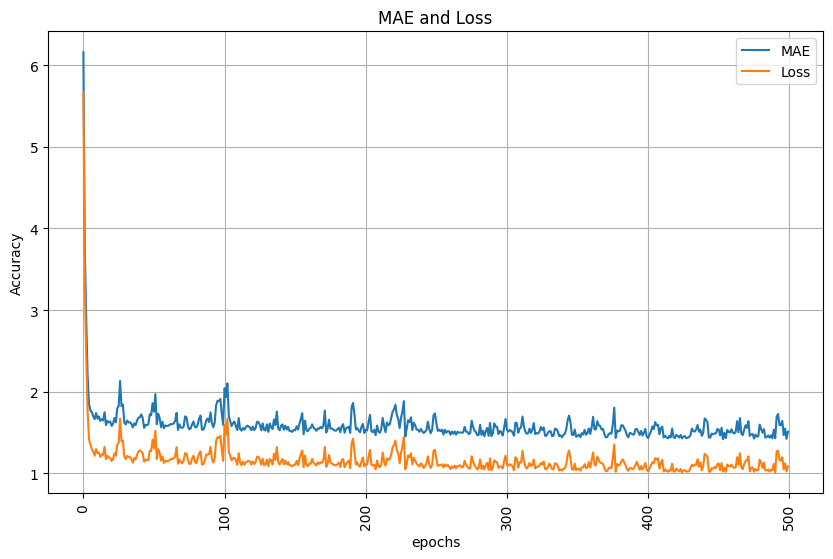

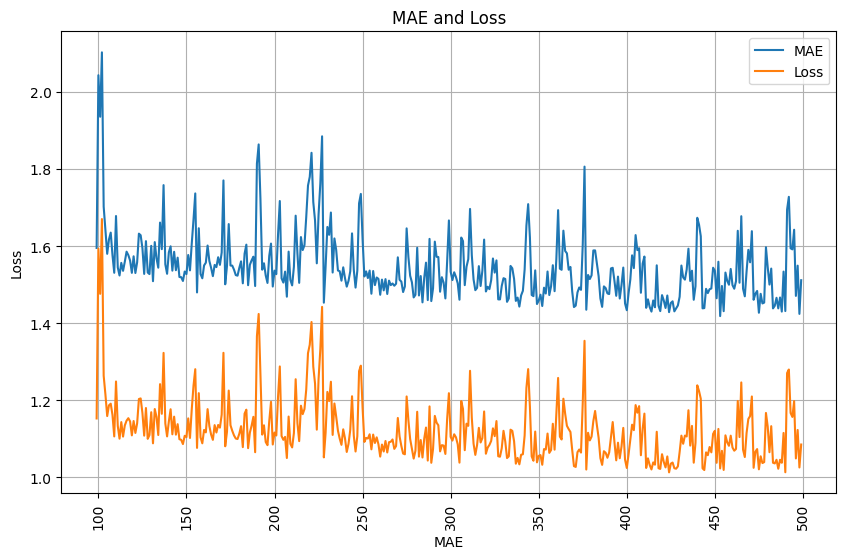

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss))

# Plot mae and loss
plot_series(
    x=epochs,
    y=(mae, loss),
    title='MAE and Loss',
    xlabel='epochs',
    ylabel='Accuracy',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom,
    y=(mae_zoom, loss_zoom),
    title='MAE and Loss',
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Model Prediction

You will then generate batches of windows to generate predictions that align with the validation set.

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

4/4 [==============================] - 1s 17ms/step


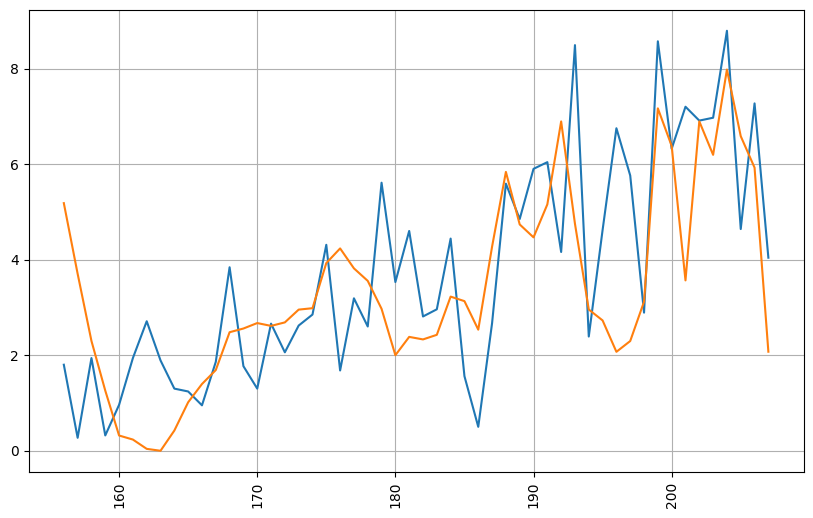

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

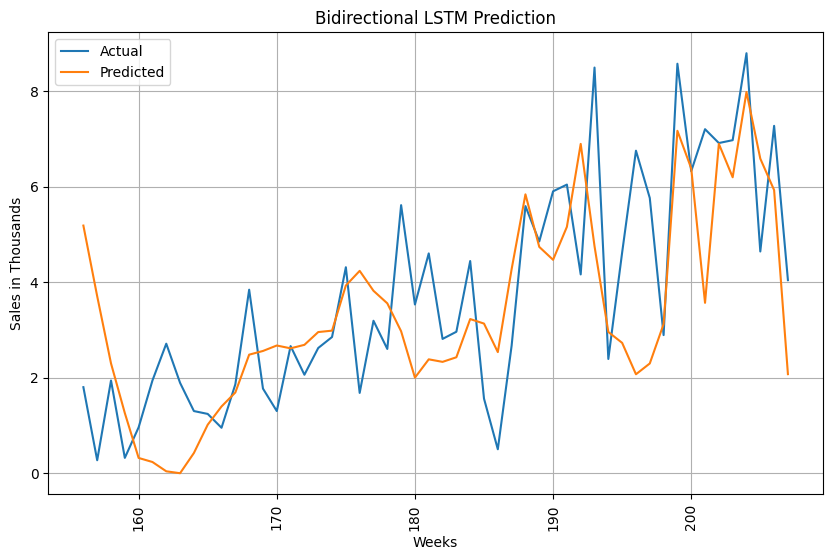

In [ ]:
plot_series(time_valid, (x_valid, results), xlabel='Weeks', ylabel='Sales in Thousands', title='Bidirectional LSTM Prediction', legend = ("Actual", "Predicted"))

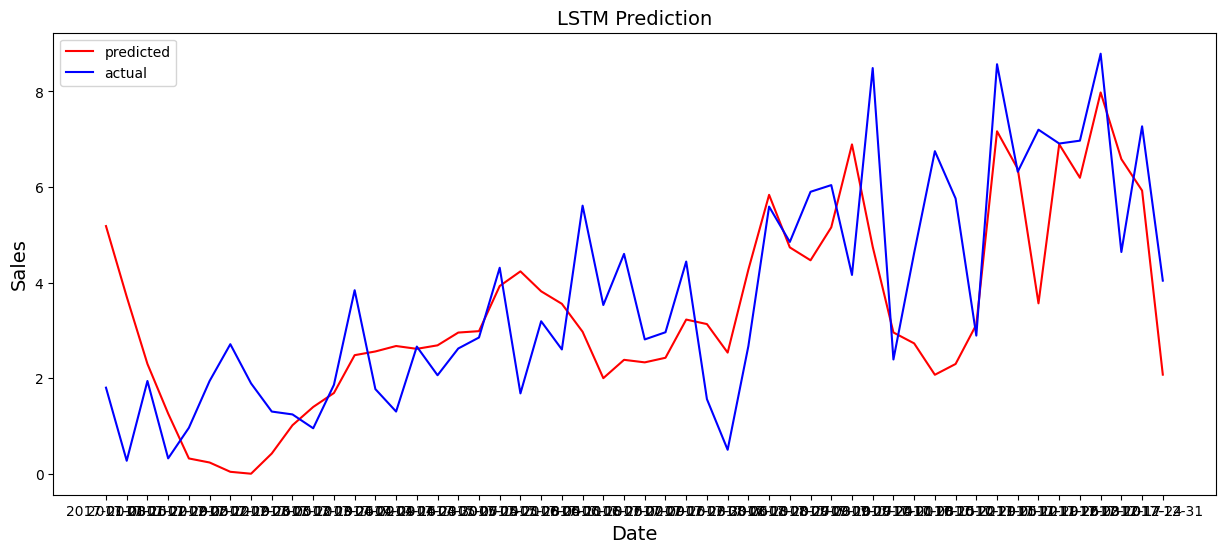

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
# Set the background color to transparent
f.patch.set_facecolor('none')
ax.set_facecolor('none')
sns.lineplot(x=date[split_time:], y=results, ax=ax, color='red', label='predicted') #navajowhite
sns.lineplot(x=date[split_time:], y=x_valid, ax=ax, color='blue', label='actual') #navajowhite
ax.set_title(f'LSTM Prediction', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Sales', fontsize=14)

plt.show()

You can then generate the metrics to evaluate the model's performance.

In [ ]:
# Compute the MSE and MAE
print(math.sqrt(tf.keras.metrics.mean_squared_error(x_valid, results).numpy()))
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

1.7850003831793537
1.378525


In [ ]:
# Assuming y_true contains the true target values and y_pred contains the predicted values
def r2_score(y_true, y_pred):
    SS_res = np.sum((y_true - y_pred)**2)
    SS_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (SS_res / SS_tot)
    return r2

In [ ]:
# Compute the MAE
print("MAE: ", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

# Compute the mean squared error
mean_squared_error = tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

# Compute the RMSE by taking the square root of the mean squared error
rmse = np.sqrt(mean_squared_error)

print("RMSE:", rmse)

r2 = r2_score(x_valid, results)
print("R2 score:", r2)

MAE:  1.378525
RMSE: 1.7850003
R2 score: 0.3851414304687445


In [ ]:
'''Best is saved do not run'''

'Best is saved do not run'

## Wrap Up

This concludes this short exercise on using LSTMs for time series forecasting. Next week, you will build upon this and add convolutions. Then, you will start to move away from synthetic data and use real-world datasets. See you there!

## Optional: Including a Validation Set while Training

Back in the first course of this specialization, you saw how you can also monitor the performance of your model against a validation set while training. You can also do that for this lab.

First, you need to generate a `val_set` which are data windows and labels that your model can accept. You can simply reuse the `windowed_dataset` function for that and you can pass in the `x_valid` points to generate the windows.

In [ ]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

You can then do the same training as before but pass in the `val_set` to the `validation_data` parameter of the `fit()` method.

In [ ]:

'''# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(dataset,epochs=100, validation_data=val_set)
'''

'# Reset states generated by Keras\ntf.keras.backend.clear_session()\n\n# Build the model\nmodel = tf.keras.models.Sequential([\n  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),\n                      input_shape=[None]),\n   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),\n  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),\n  tf.keras.layers.Dense(1),\n  tf.keras.layers.Lambda(lambda x: x * 100.0)\n])\n\n# Set the learning rate\nlearning_rate = 2e-6\n\n# Set the optimizer\noptimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)\n\n# Set the training parameters\nmodel.compile(loss=tf.keras.losses.Huber(),\n              optimizer=optimizer,\n              metrics=["mae"])\n\n# Train the model\nhistory = model.fit(dataset,epochs=100, validation_data=val_set)\n'